In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import gzip
import shutil

import SimpleITK as sitk
image_viewer = sitk.ImageViewer()
# image_viewer.SetApplication('/Applications/Slicer.app/Contents/MacOS/Slicer')
image_viewer.SetApplication('/Applications/Fiji.app/Contents/MacOS/ImageJ-macosx')

%matplotlib inline
import matplotlib.pyplot as plt

#### Read data

In [2]:
dataset_folder = Path(os.getcwd()+'/dataset')

data = pd.read_excel(dataset_folder/Path('Pretreat-MetsToBrain-Masks_clin_20230918.xlsx'),sheet_name='Data')
description = pd.read_excel(dataset_folder/Path('Pretreat-MetsToBrain-Masks_clin_20230918.xlsx'),sheet_name='Description')

In [6]:
pd.set_option('display.max_colwidth', 0)

In [8]:
data

,BraTS_MET_ID,Age,Sex,Ethnicity,Smoke,Primary,Extranodal,Survival,Death,Infratentorial,ET_num,Nec_num,Edema_num,ET_vol,Nec_vol,Edema_vol,Nec_ET_ratio,Edema_ET_ratio
0,86,43.684932,1,0,2.5,1,1.0,92.166667,0.0,1,3,0,3,0.458,0.000,3.469,0.000000,7.574236
1,89,56.958904,1,0,9.0,4,1.0,21.266667,1.0,0,1,0,1,0.487,0.000,0.267,0.000000,0.548255
2,90,57.482192,1,0,37.5,6,0.0,27.000000,1.0,1,2,0,1,0.061,0.000,0.142,0.000000,2.327869
3,96,75.536986,0,0,20.0,5,0.0,84.166667,0.0,1,2,1,1,0.288,0.045,0.114,0.135135,0.342342
4,97,64.728767,1,0,NaN,5,0.0,4.666667,0.0,1,3,2,2,2.242,2.830,4.912,0.557965,0.968454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,305,53.460274,1,0,10.0,5,1.0,17.566667,1.0,1,6,2,5,2.283,0.284,2.252,0.110635,0.877289
196,306,69.515068,0,0,0.0,4,0.0,77.733333,0.0,0,7,1,6,29.150,0.807,145.732,0.026939,4.864706
197,307,53.624658,1,0,17.5,3,0.0,29.966667,0.0,0,1,1,1,1.450,0.721,81.500,0.332105,37.540304
198,309,84.709589,1,0,40.0,5,1.0,38.433333,1.0,0,2,0,2,0.130,0.000,0.168,0.000000,1.292308


#### Mappings

In [10]:
Sex = {"0": "Male", "1": "Female"}
Ethnicity = {"0": "White", "1": "White Hispanic", "2": "White/Black", "3": "Black", "4": "Asian/Pacific Islander"}
Primary = {"1": "Breast cancer", "2": "Gastrointestinal cancers", "3": "Small cell lung cancer", "4": "Melanoma", "5": "Non small cell lung cancer", "6": "Renal cell carcinoma", "7": "Other"}
Extranodal = {"0": "No", "1": "Yes"}
Death = {"0": "No", "1": "Yes"}
Infratentorial = {"0": "No", "1": "Yes"}

##### Data Selection

In [36]:
def transform_to_single_roi(image_path):
    """
    Reads image from image_path and merges the different ROIs to 1 ROI.
    At the end stores the mapped_image to the same image_path
    """
    image = sitk.ReadImage(image_path)
    array = sitk.GetArrayFromImage(image)
    print(f"Before: {np.unique(array)}, {array.shape}")
    mapped_array = np.where(array == 0, 0, 1).astype("uint16")
    print(f"After: {np.unique(mapped_array)}, {mapped_array.shape}")
    mapped_image = sitk.GetImageFromArray(mapped_array)
    mapped_image.SetSpacing(image.GetSpacing())
    mapped_image.SetOrigin(image.GetOrigin())
    mapped_image.SetDirection(image.GetDirection())
    sitk.WriteImage(mapped_image, image_path)

In [38]:
# rootdir = dataset_folder/Path("test")
rootdir = dataset_folder/Path("Pretreat-MetsToBrain-Masks") # directory with the complete dataset
newdir = dataset_folder/Path("dataset_to_process") # directory to store data we are interested in
if not os.path.exists(newdir): # Create directory if doesn't exist
    os.mkdir(newdir)

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith('.gz') and (file[-10:-7] == 't2w' or file[-10:-7] == 'seg'): # filter files by extension (gz) and scan type (t2w, seg)
            # Copy desired data to dedicated folder
            print(subdir, file)
            sample_name = subdir.split('/')[-1] # Get the name of the subdirectory for each sample
            new_subdir = Path(newdir)/Path(sample_name)
            if not os.path.exists(new_subdir):
                os.mkdir(new_subdir)
            shutil.copy(Path(subdir)/Path(file), new_subdir/Path(file)) # copy from original dataset folder to a new directory
            
            # Unzip and delete gz file
            filepath = os.path.join(new_subdir, file)
            output_filepath = filepath[:-3] # filename without .gz extension
            print(output_filepath)
            with gzip.open(filepath, 'rb') as f_in: # Read from one file
                with open(output_filepath, 'wb') as f_out: # Write to the other file
                    shutil.copyfileobj(f_in, f_out)
            os.remove(filepath)

            # Merge ROIs
            if file[-10:-7] == 'seg':
                transform_to_single_roi(output_filepath)


/Users/stelios/workspace/stelios/pyradiomics/v2/dataset/Pretreat-MetsToBrain-Masks/BraTS-MET-00086-000 BraTS-MET-00086-000-t2w.nii.gz
/Users/stelios/workspace/stelios/pyradiomics/v2/dataset/dataset_to_process/BraTS-MET-00086-000/BraTS-MET-00086-000-t2w.nii
/Users/stelios/workspace/stelios/pyradiomics/v2/dataset/Pretreat-MetsToBrain-Masks/BraTS-MET-00086-000 BraTS-MET-00086-000-seg.nii.gz
/Users/stelios/workspace/stelios/pyradiomics/v2/dataset/dataset_to_process/BraTS-MET-00086-000/BraTS-MET-00086-000-seg.nii
Before: [0. 2. 3.], (155, 240, 240)
After: [0 1], (155, 240, 240)
/Users/stelios/workspace/stelios/pyradiomics/v2/dataset/Pretreat-MetsToBrain-Masks/BraTS-MET-00284-000 BraTS-MET-00284-000-seg.nii.gz
/Users/stelios/workspace/stelios/pyradiomics/v2/dataset/dataset_to_process/BraTS-MET-00284-000/BraTS-MET-00284-000-seg.nii
Before: [0. 1. 2. 3.], (155, 240, 240)
After: [0 1], (155, 240, 240)
/Users/stelios/workspace/stelios/pyradiomics/v2/dataset/Pretreat-MetsToBrain-Masks/BraTS-MET-0

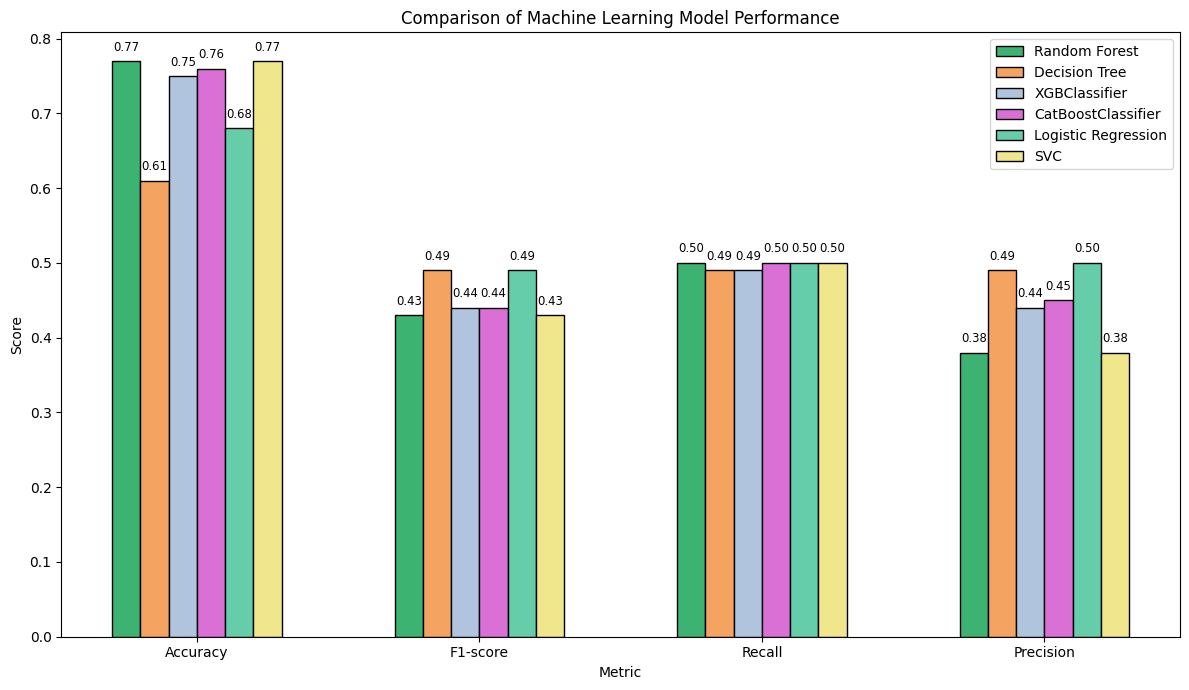

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define metrics and models
metrics = ['Accuracy', 'F1-score', 'Recall', 'Precision']
models = ['Random Forest', 'Decision Tree', 'XGBClassifier', 'CatBoostClassifier', 'Logistic Regression', 'SVC']
colors = ['mediumseagreen', 'blue', 'blue', 'blue', 'blue', 'blue']

# Scores for each model (You can replace these values with your actual data)
scores = {
    'Random Forest': [0.77, 0.43, 0.50, 0.38],
    'Decision Tree': [0.61, 0.49, 0.49, 0.49],
    'XGBClassifier': [0.75, 0.44, 0.49, 0.44],
    'CatBoostClassifier': [0.76, 0.44, 0.50, 0.45],
    'Logistic Regression': [0.68, 0.49, 0.50, 0.50],
    'SVC': [0.77, 0.43, 0.50, 0.38]
}

colors = {
    'Random Forest': 'mediumseagreen',
    'Decision Tree': 'sandybrown',
    'XGBClassifier': 'lightsteelblue',
    'CatBoostClassifier': 'orchid',
    'Logistic Regression': 'mediumaquamarine',
    'SVC': 'khaki'
}

# Set up bar width and positions
bar_width = 0.10
index = np.arange(len(metrics))

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 7))

# Plot each model's performance across the metrics
for i, model in enumerate(models):
    ax.bar(index + i * bar_width, scores[model], bar_width, label=model, color=colors[model], edgecolor=['black'])

# Add labels, title, and legend
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Machine Learning Model Performance')
ax.set_xticks(index + bar_width * 2.5)
ax.set_xticklabels(metrics)
ax.legend()

# Add values on top of each bar
for i, model in enumerate(models):
    for j, score in enumerate(scores[model]):
        ax.text(index[j] + i * bar_width, score + 0.01, f'{score:.2f}', ha='center', va='bottom', fontsize='small')

# Display the plot
plt.tight_layout()
plt.show()


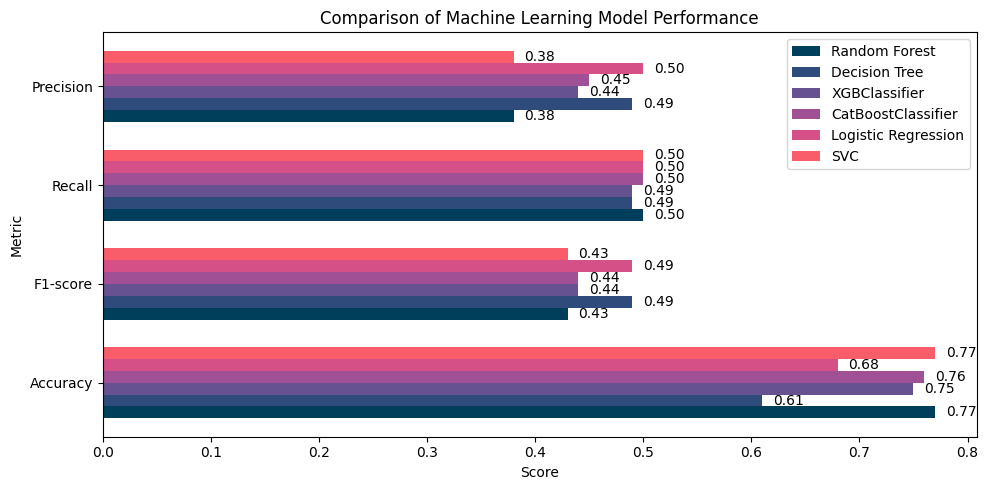

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define metrics and models
metrics = ['Accuracy', 'F1-score', 'Recall', 'Precision']
models = ['Random Forest', 'Decision Tree', 'XGBClassifier', 'CatBoostClassifier', 'Logistic Regression', 'SVC']

# Scores for each model (replace with your actual data)
scores = {
    'Random Forest': [0.77, 0.43, 0.50, 0.38],
    'Decision Tree': [0.61, 0.49, 0.49, 0.49],
    'XGBClassifier': [0.75, 0.44, 0.49, 0.44],
    'CatBoostClassifier': [0.76, 0.44, 0.50, 0.45],
    'Logistic Regression': [0.68, 0.49, 0.50, 0.50],
    'SVC': [0.77, 0.43, 0.50, 0.38]
}

# Custom colors for each model
colors = [
    '#003f5c',  # Darkest blue
    '#2f4b7c',  # Dark blue
    '#665191',  # Purple-blue
    '#a05195',  # Violet-blue
    '#d45087',  # Light violet-blue
    '#f95d6a',  # Pinkish-blue
]
cmap={}
for c,m in zip(colors,models):
    cmap[m]=c

# Set up bar width and positions
bar_height = 0.12
index = np.arange(len(metrics))

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each model's performance across the metrics using horizontal bars
for i, model in enumerate(models):
    ax.barh(index + i * bar_height, scores[model], bar_height, label=model, color=cmap[model])

# Add labels, title, and legend
ax.set_ylabel('Metric')
ax.set_xlabel('Score')
ax.set_title('Comparison of Machine Learning Model Performance')
ax.set_yticks(index + bar_height * 2.5)
ax.set_yticklabels(metrics)
ax.legend()

# Add values on top of each bar
for i, model in enumerate(models):
    for j, score in enumerate(scores[model]):
        ax.text(score + 0.01, index[j] + i * bar_height, f'{score:.2f}', va='center', ha='left')

# Display the plot
plt.tight_layout()
plt.show()


In [36]:
TP = 15
FP = 5
TN = 20
FN = 0

In [37]:
(TP + TN) / (TP + FP + FN + TN)

0.875

In [38]:
TP/ (TP + FN)

1.0

In [39]:
(TN) / (TN + FP)

0.8

In [ ]:
# Store setup settings
rows_to_drop = [5, 6, 8, 9, 10, 11, 18, 20]
setup_settings = clf._display_container[0].copy()
setup_settings = setup_settings.drop(rows_to_drop, axis=0)
setup_settings.reset_index(drop=True, inplace=True)
store_path = f'./results/{experiment_name}/setup_settings.png'
save_df_to_png(setup_settings, store_path)

Stored df in ./results/remove_outliers/setup_settings.png


In [ ]:
# Store setup settings
rows_to_drop = [5, 6, 8, 9, 10, 11, 18, 20]
setup_settings = clf._display_container[0].copy()
setup_settings = setup_settings.drop(rows_to_drop, axis=0)
setup_settings.reset_index(drop=True, inplace=True)
store_path = f'./results/{experiment_name}/setup_settings.png'
save_df_to_png(setup_settings, store_path)

Stored df in ./results/remove_outliers/setup_settings.png
